**该jupyter用于绘制CED网络涉及到的图片**

# 导入画图通用模块

In [8]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import scipy as sp
import sys
import torch
import multiprocessing as mp
sys.path.insert(0, '../shared_modules/')
import plot_utils
sys.path.append('../CED_train/')
from analysis import load_model, load_testdataset, plot_result

In [3]:
# 画图过程中的全局变量
DT = 0.002
T_GAIN = 2.5
DX,DZ = 5., 5.
NX,NZ = 128, 128
VLIM = 0.6
CLIM = (1500,3600)
NREC,NSTEPS = 32, 512
DELTARECi = 3

# define gain profile for display
t_gain = np.arange(NSTEPS, dtype=np.float32)**T_GAIN
t_gain = t_gain/np.median(t_gain)
t_gain = t_gain.reshape((1,1,1,NSTEPS))# along NSTEPS
letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
modle_freedom=['1','2','3','4']
it = iter(modle_freedom) 

# 绘制生成数据展示图片

In [7]:
VEL_RUN = "anomalies_freedom4_100"
SIM_RUN = "anomalies_freedom4_100_3sources"
DELTARECi = 3
isim=(0,0)
rootdir = '../generate_data/'
VEL_DIR =  rootdir + "velocity/" + VEL_RUN + "/"
OUT_SIM_DIR = rootdir + "gather/" + SIM_RUN + "/"
wavefields = np.load(OUT_SIM_DIR + "wavefields_%.8i_%.8i.npy"%(isim[0],isim[1]))
wavefields = wavefields[::4]
gather = np.load(OUT_SIM_DIR + "gather_%.8i_%.8i.npy"%(isim[0],isim[1]))
velocity = np.load(VEL_DIR + "velocity_%.8i.npy"%(isim[0]))
source_is = np.load(OUT_SIM_DIR + "source_is.npy")
receiver_is = np.load(OUT_SIM_DIR + "receiver_is.npy")
source_i = source_is[isim[0],isim[1]]
NREC = len(receiver_is)

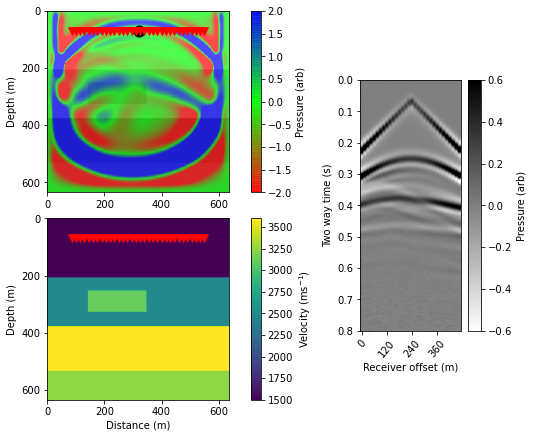

In [10]:
gain = np.arange(NSTEPS)**T_GAIN
gain = gain / np.median(gain)
gain = gain.reshape((1,NSTEPS))

plt.figure(figsize=(11,6))

# velocity & wavefield
plt.subplot2grid((6, 6), (0, 0), colspan=3, rowspan=3)
plt.imshow(velocity.T, alpha=0.6, cmap="gray_r", vmin=CLIM[0], vmax=CLIM[1])
plt.imshow(wavefields[135].T, aspect=1, cmap=plot_utils.rgb, alpha=0.7, vmin = -2, vmax=2)
cb = plt.colorbar()
cb.ax.set_ylabel('Pressure (arb)')
plt.scatter(source_i[0], source_i[1], color='black', s=120)
plt.scatter(receiver_is[:,0], receiver_is[:,1], color='red', marker='v', s=60)
plt.gca().set_anchor('C')# centre plot
plt.yticks(np.arange(0,NZ,40)[::-1], (DZ*np.arange(0,NZ,40)[::-1]).astype(np.int))
plt.xticks(np.arange(0,NX,40), (DX*np.arange(0,NX,40)).astype(np.int))
plt.ylabel("Depth (m)")
plt.xlim(0, NX-1)
plt.ylim(NZ-1, 0)

# velocity
plt.subplot2grid((6, 6), (3, 0), colspan=3, rowspan=3)
plt.imshow(velocity.T, vmin=CLIM[0], vmax=CLIM[1])
cb = plt.colorbar()
cb.ax.set_ylabel('Velocity ($\mathrm{ms}^{-1}$)')
plt.scatter(receiver_is[:,0], receiver_is[:,1], color='red', marker='v', s=60)
plt.gca().set_anchor('C')# centre plot
plt.yticks(np.arange(0,NZ,40)[::-1], (DZ*np.arange(0,NZ,40)[::-1]).astype(np.int))
plt.xticks(np.arange(0,NX,40), (DX*np.arange(0,NX,40)).astype(np.int))
plt.xlabel("Distance (m)")
plt.ylabel("Depth (m)")
plt.xlim(0, NX-1)
plt.ylim(NZ-1, 0)

# gather
plt.subplot2grid((6, 6), (1, 3), rowspan=4, colspan=2)
plt.imshow((gain*gather).T, aspect=0.2, cmap="gray_r", vmin=-VLIM, vmax=VLIM)
plt.xlabel("Receiver offset (m)")
plt.xticks(np.arange(0,NREC,8), (DX*DELTARECi*np.arange(0,NREC,8)).astype(np.int))
plt.yticks(np.arange(0,NSTEPS,50)[::-1], (["%.1f"%(val) for val in DT*np.arange(0,NSTEPS,50)[::-1]]))
plt.ylabel("Two way time (s)")
plt.ylim(400,0)
plt.gca().set_anchor('C')# centre plot
plt.xticks(rotation=50)
cb = plt.colorbar()
cb.ax.set_ylabel('Pressure (arb)')

plt.subplots_adjust(left=0.2, right=0.9, bottom=0.1, top=1., hspace=0.6, wspace=1.)

figout_dir = './Fig/data_example/'
if not os.path.exists(figout_dir):
    os.makedirs(figout_dir)
plt.savefig(figout_dir+"CED_data_example.png", bbox_inches='tight', pad_inches=0.01, dpi=300,facecolor='w')

# 绘制地震波传播GIF

In [4]:

VEL_RUN = "anomalies_freedom4_100"
SIM_RUN = "anomalies_freedom4_100_3sources"
DELTARECi = 3
isim=(0,0)
rootdir = '../generate_data/'
VEL_DIR =  rootdir + "velocity/" + VEL_RUN + "/"
OUT_SIM_DIR = rootdir + "gather/" + SIM_RUN + "/"
wavefields = np.load(OUT_SIM_DIR + "wavefields_%.8i_%.8i.npy"%(isim[0],isim[1]))
wavefields = wavefields[::4]
gather = np.load(OUT_SIM_DIR + "gather_%.8i_%.8i.npy"%(isim[0],isim[1]))
velocity = np.load(VEL_DIR + "velocity_%.8i.npy"%(isim[0]))
source_is = np.load(OUT_SIM_DIR + "source_is.npy")
receiver_is = np.load(OUT_SIM_DIR + "receiver_is.npy")

DELTAT = 0.002
source_i = source_is[isim[0],isim[1]]

print(velocity.shape, velocity[0,0])
print(wavefields.shape, np.max(wavefields))
print(gather.shape)
print(receiver_is.shape, source_is.shape)
#print(receiver_is)
#print(source_is)
print(source_i)

(128, 128) 1500.0
(512, 128, 128) 98.9955
(32, 512)
(32, 2) (100, 1, 2)
[64 14]


<IPython.core.display.Javascript object>


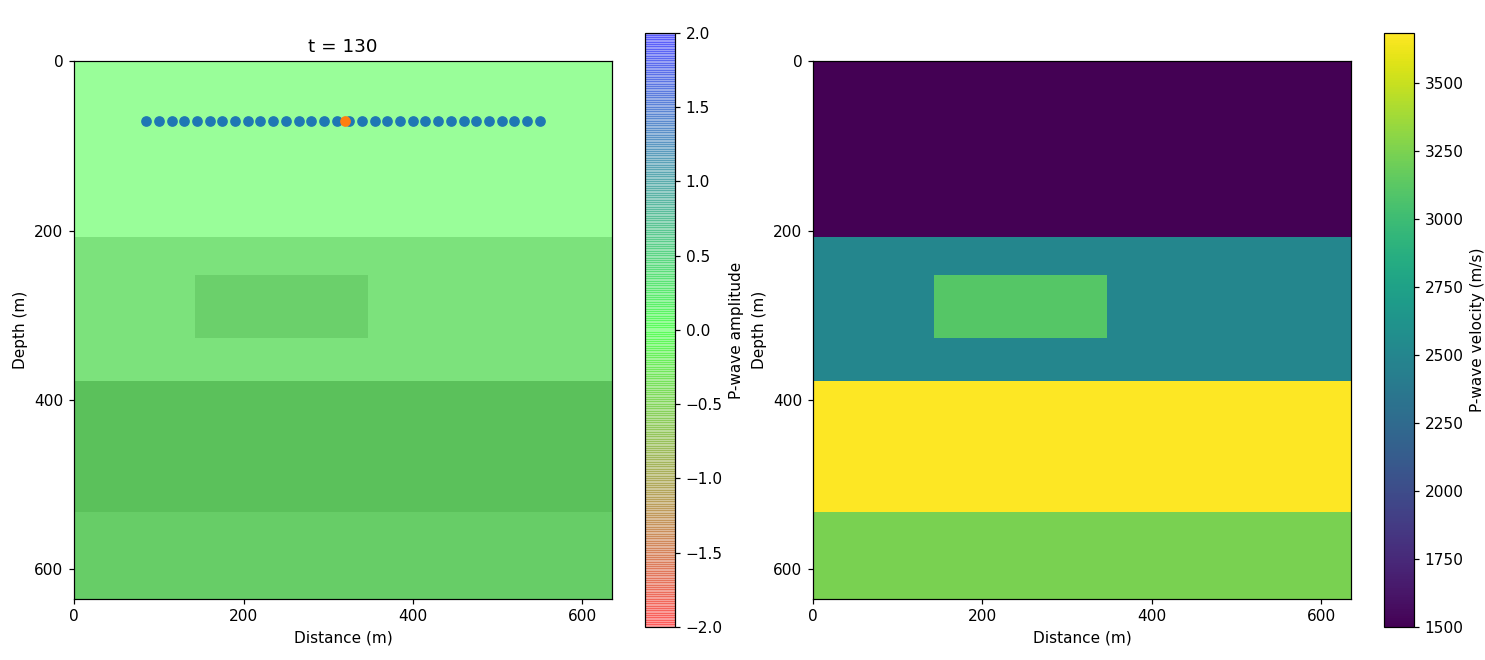

MovieWriter Pillow unavailable; using Pillow instead.


range(0, 512, 10)


In [5]:
# define initial plots
%matplotlib notebook
fig = plt.figure(figsize=(13.5,6))
plt.subplot(1,2,2)
plt.imshow(velocity.T, cmap="viridis")
plt.xticks(np.arange(0,NX,40), (DX*np.arange(0,NX,40)).astype(np.int))
plt.xlabel("Distance (m)")
plt.yticks(np.arange(0,NZ,40)[::-1], (DZ*np.arange(0,NZ,40)[::-1]).astype(np.int))
plt.xlim(0,NX-1)
plt.ylim(NZ-1,0)
plt.ylabel("Depth (m)")
cb = plt.colorbar()
cb.ax.set_ylabel('P-wave velocity (m/s)')
plt.subplot(1,2,1)
plt.imshow(velocity.T, alpha=0.4, cmap="gray_r")
plt.xticks(np.arange(0,NX,40), (DX*np.arange(0,NX,40)).astype(np.int))
plt.xlabel("Distance (m)")
plt.yticks(np.arange(0,NZ,40)[::-1], (DZ*np.arange(0,NZ,40)[::-1]).astype(np.int))
plt.xlim(0,NX-1)
plt.ylim(NZ-1,0)
plt.ylabel("Depth (m)")
im = plt.imshow(wavefields[0].T, aspect=1, cmap=plot_utils.rgb, alpha=0.4, vmin = -2, vmax=2)
cb = plt.colorbar()
cb.ax.set_ylabel('P-wave amplitude')
plt.scatter(receiver_is[:,0], receiver_is[:,1])
plt.scatter(source_i[0], source_i[1])

# define animation update function
def update(i):
    # set the data in the im object
    plt.title("t = %i"%(i))
    im.set_data(wavefields[i].T)
    return [im]# tells the animator which parts of the plot to update
# start animation
# important: keep the instance to maintain timer
ani = animation.FuncAnimation(fig, update, frames=range(0,wavefields.shape[0],10), interval=100, blit=False)

plt.subplots_adjust(left=0.05, right=1., bottom=0.05, top=0.95, hspace=0.0, wspace=0.1)
plt.show()
frames=range(0,wavefields.shape[0],10)
print(frames)

figout_dir = './Fig/data_example/'
if not os.path.exists(figout_dir):
    os.makedirs(figout_dir)
ani.save(figout_dir+'wavefields.gif',writer='Pillow')

In [16]:
ani._stop()

# 绘制不同数目随机震源对比图

## 速度模型对比图 

In [7]:
path = '../CED_train/'
model, c_dict = load_model("anomalies_freedom4_2000_9sources", rootdir=path+"results/",verbose=False)
# print(c_dict['DATA_PATH'])
# c_dict['DATA_PATH'] = './seismic-simulation-complex-media-master_anomalies/generate_data_Anomalies/data'
# print(c_dict['DATA_PATH'])
rootdir = '../generate_data/data'
anomalies_1 = load_testdataset("anomalies_freedom0_500_3sources.bin", N_EXAMPLES=1500, c_dict=c_dict, rootdir=rootdir ,verbose=False)
anomalies_2 = load_testdataset("anomalies_freedom0_150_10sources.bin", N_EXAMPLES=1500, c_dict=c_dict, rootdir=rootdir ,verbose=False)
sample_index = 4
n_source = 3
irange = np.arange(n_source*(sample_index -1 ),n_source*(sample_index))
anomalies_1.open_file_reader()
samples = [anomalies_1[i] for i in irange]
anomalies_1.close_file_reader()
inputs = [torch.cat([sample["inputs"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["inputs"]))]
labels = [torch.cat([sample["labels"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["labels"]))]
for i in inputs: print(i.shape)
for i in labels: print(i.shape)
# print(inputs)
inputs_array_1 = inputs[0].numpy()
source_array_1 = inputs[1].numpy()
labels_array_1 = labels[0].numpy()
#########################################
n_source = 10
irange = np.arange(n_source*(sample_index -1 ),n_source*(sample_index))
anomalies_2.open_file_reader()
samples = [anomalies_2[i] for i in irange]
anomalies_2.close_file_reader()
inputs = [torch.cat([sample["inputs"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["inputs"]))]
labels = [torch.cat([sample["labels"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["labels"]))]
for i in inputs: print(i.shape)
for i in labels: print(i.shape)
# print(inputs)
inputs_array_2 = inputs[0].numpy()
source_array_2 = inputs[1].numpy()
labels_array_2 = labels[0].numpy()

inputs_array_1 = c_dict["VELOCITY_SIGMA"]*inputs_array_1 + c_dict["VELOCITY_MU"]# 将归一化的数据恢复
inputs_array_2 = c_dict["VELOCITY_SIGMA"]*inputs_array_2 + c_dict["VELOCITY_MU"]# 将归一化的数据恢复

Loading model from: ../CED_train/results/models/anomalies_freedom4_2000_9sources/model_00100000.torch
1500 examples
[   0    1    2 ... 1497 1498 1499]
1500 examples
[   0    1    2 ... 1497 1498 1499]
torch.Size([3, 1, 128, 128])
torch.Size([3, 2, 1, 1])
torch.Size([3, 1, 32, 512])
torch.Size([10, 1, 128, 128])
torch.Size([10, 2, 1, 1])
torch.Size([10, 1, 32, 512])


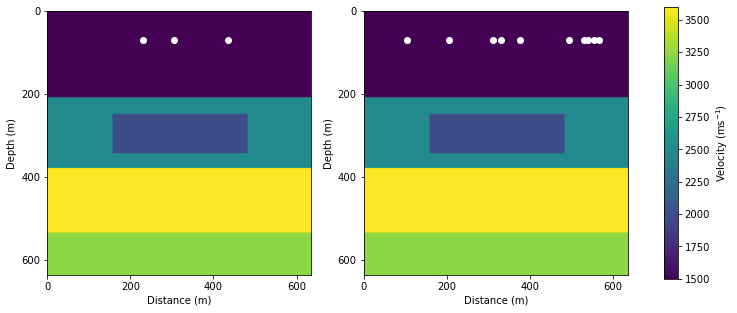

In [11]:
%matplotlib inline
f = plt.figure(figsize=(13,5))
ax1 = plt.subplot(121)
ss=ax1.imshow(inputs_array_1[0,0,:,:].T, vmin=CLIM[0], vmax=CLIM[1])
plt.xticks(np.arange(0,NX,40), (DX*np.arange(0,NX,40)).astype(np.int))
plt.xlabel("Distance (m)")
plt.yticks(np.arange(0,NZ,40)[::-1], (DZ*np.arange(0,NZ,40)[::-1]).astype(np.int))
plt.xlim(0,NX-1)
plt.ylim(NZ-1,0)
plt.ylabel("Depth (m)")
for i in range(3):
    ax1.scatter(NX*source_array_1[i,0,:,:], NX*source_array_1[i,1,:,:], c="white")
# ax1.scatter(NX*source_array_1[1,0,:,:], NX*source_array_1[1,1,:,:], c="white")

ax2 = plt.subplot(122)
ax2.imshow(inputs_array_2[0,0,:,:].T, vmin=CLIM[0], vmax=CLIM[1])
plt.xticks(np.arange(0,NX,40), (DX*np.arange(0,NX,40)).astype(np.int))
plt.xlabel("Distance (m)")
plt.yticks(np.arange(0,NZ,40)[::-1], (DZ*np.arange(0,NZ,40)[::-1]).astype(np.int))
plt.xlim(0,NX-1)
plt.ylim(NZ-1,0)
plt.ylabel("Depth (m)")
for i in range(10):
    ax2.scatter(NX*source_array_2[i,0,:,:], NX*source_array_2[i,1,:,:], c="white")
cb = f.colorbar(ss,ax = [ax1,ax2])
cb.ax.set_ylabel('Velocity ($\mathrm{ms}^{-1}$)')


figout_dir = './Fig/forward/sources/'
if not os.path.exists(figout_dir):
    os.makedirs(figout_dir)
plt.savefig(figout_dir+'freedom0_velocity_comparison.png',dpi=300,facecolor='w')#保存图片


## loss曲线对比图

In [75]:
PATH = ('../CED_train/results/summaries/')
l1loss_test = 'run-.-tag-loss_l1_loss_test.csv'
l1loss_train = 'run-.-tag-loss_l1_loss_train.csv'

modle = ['anomalies_freedom0_500_3sources/','anomalies_freedom0_150_10sources/']
x_v = []
x_t = []
y_v = []
y_t = []

for i in range(len(modle)):
    data = pd.read_csv(PATH + modle[i] + l1loss_test)
    x_v.append(data['Step'].tolist())
    y_v.append(data['Value'].tolist())
    data = pd.read_csv(PATH + modle[i] + l1loss_train)
    x_t.append(data['Step'].tolist())
    y_t.append(data['Value'].tolist())
titles = ['3 sources','10 sources']

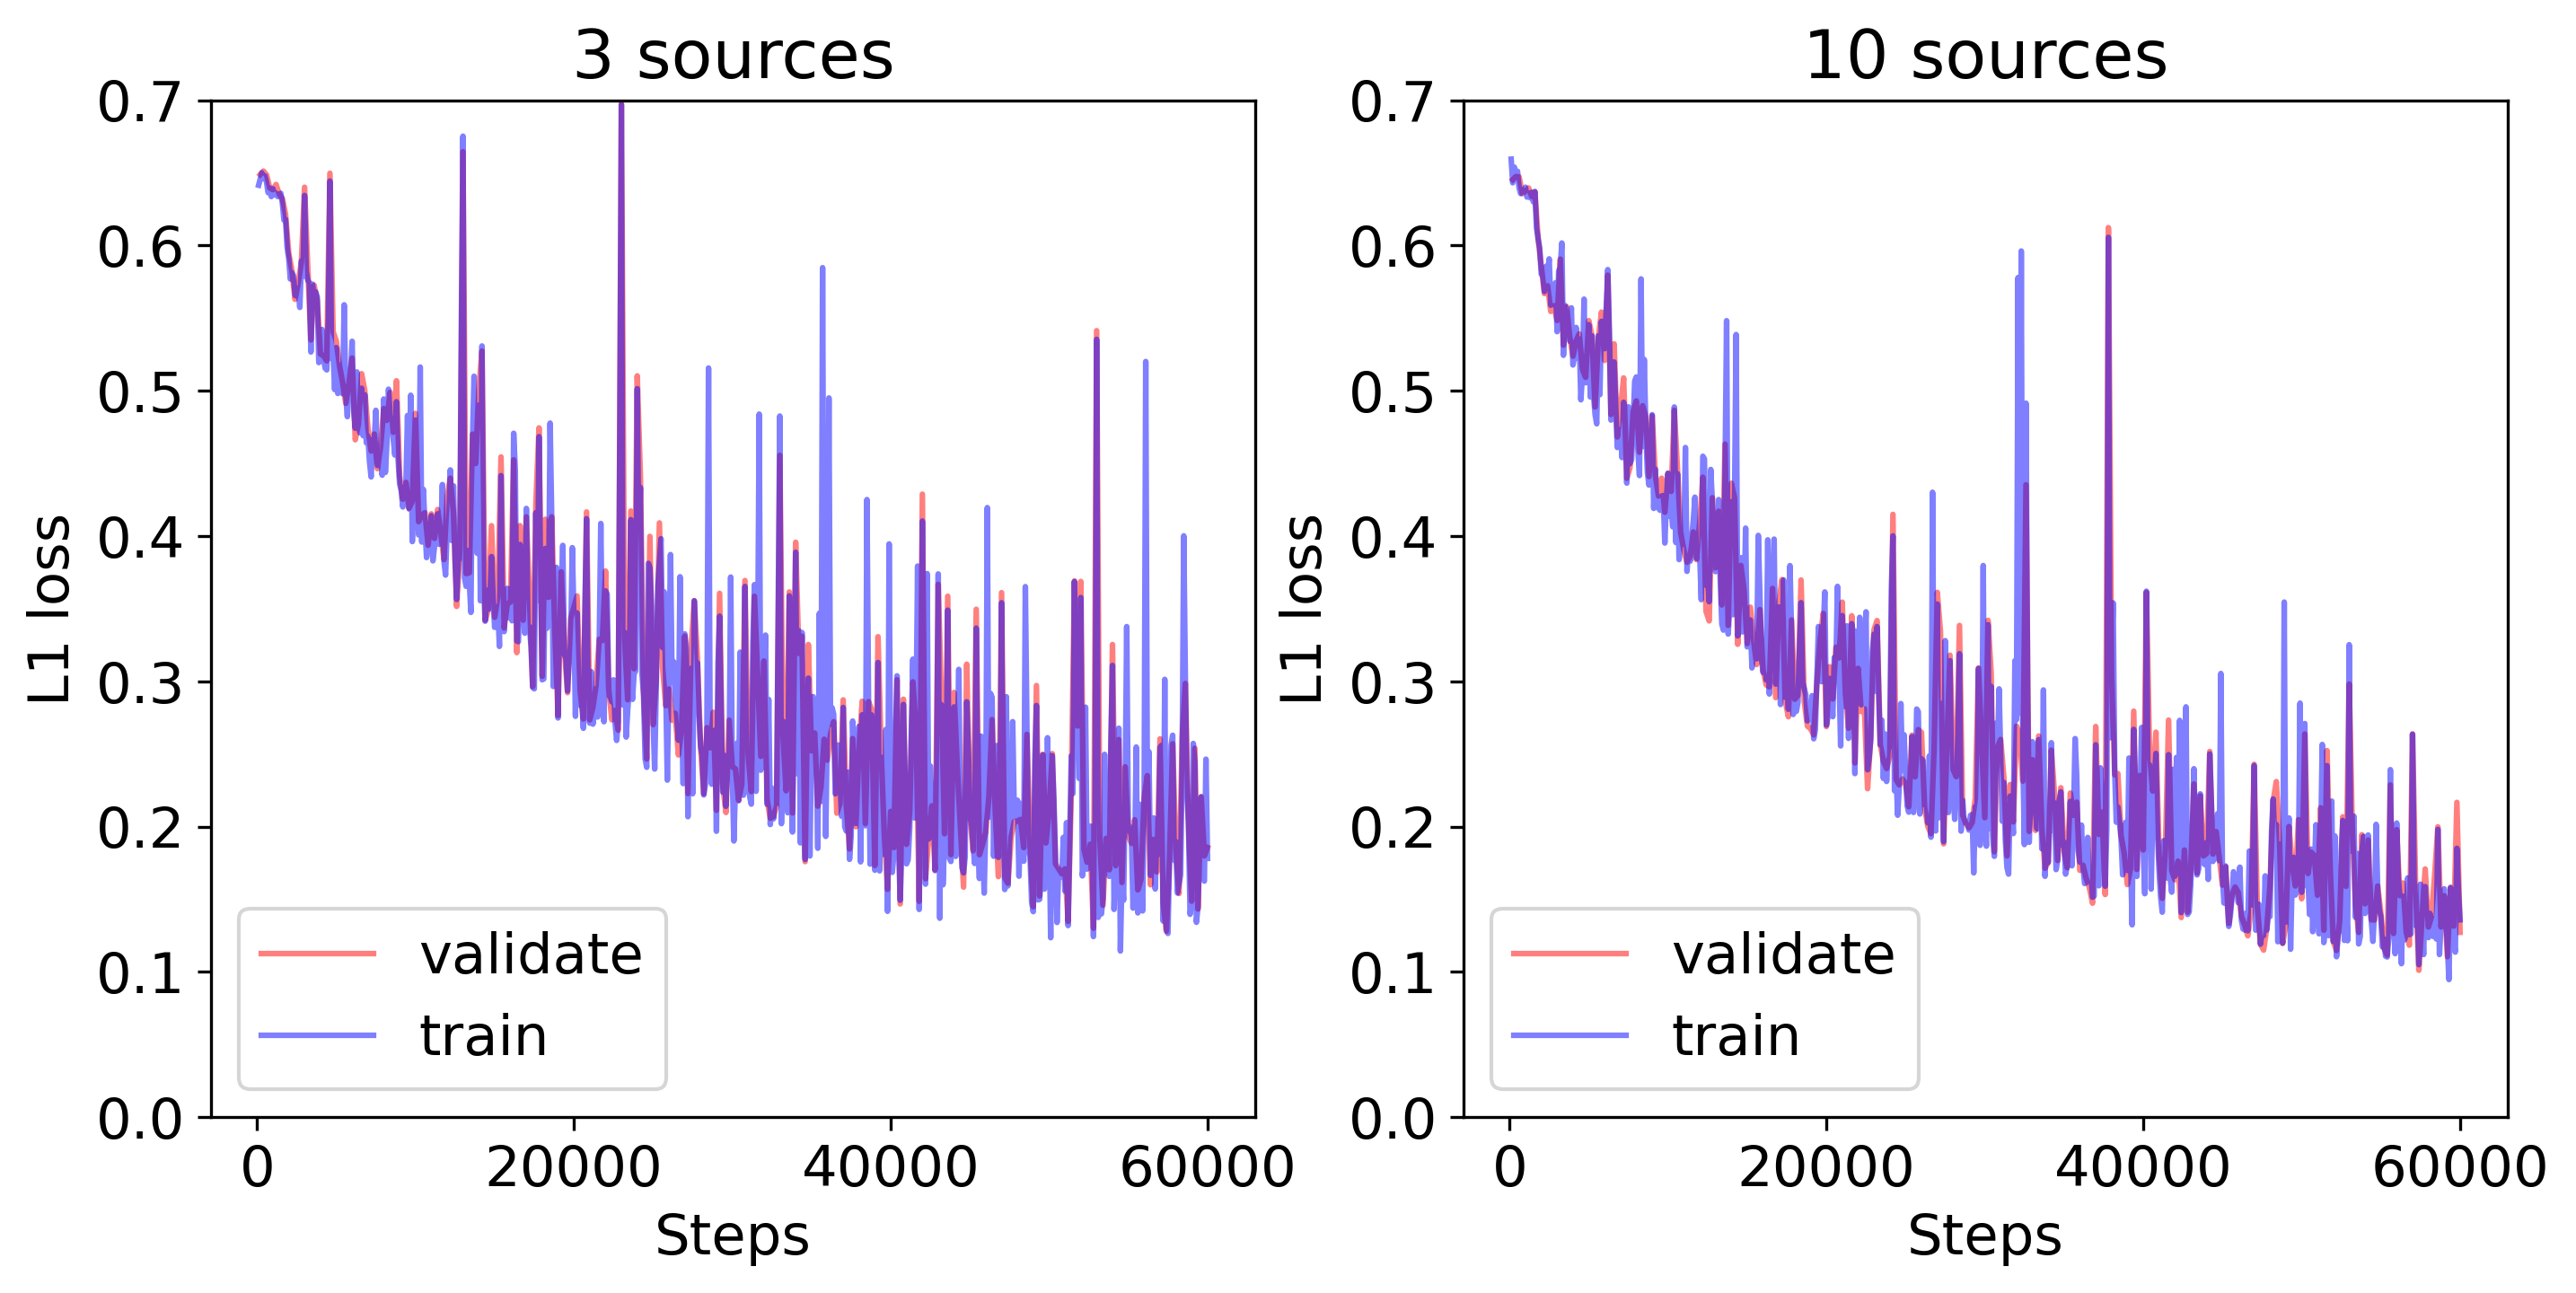

In [76]:
fig = plt.figure(num=1, figsize=(11, 5),dpi=300)     #开启一个窗口，同时设置大小，分辨率
# plt.plot(test_Step,l1loss_test,linestyle='-',alpha=0.5,color='r',label='validate')
# plt.plot(train_Step,l1loss_train,linestyle='-',alpha=0.5,color='b',label='train')
# plt.legend()
# plt.xlabel('Steps')
# plt.ylabel('L1 loss')
# plt.ylim([0,0.8])
# plt.xlim([-5000,105000])
# plt.title('')
# plt.savefig('./Fig/forward/samples/freedom4_2000_9sources_loss.png',dpi=300,facecolor='w')#保存图片
for i in range(len(modle)):
    plt.subplot(1,len(modle),i+1)
    plt.plot(x_v[i],y_v[i],linestyle='-',alpha=0.5,color='r',label='validate')
    plt.plot(x_t[i],y_t[i],linestyle='-',alpha=0.5,color='b',label='train')
    plt.legend()
    plt.xlabel('Steps')
    plt.ylabel('L1 loss')
    plt.ylim([0,0.7])
    plt.title('%s'%titles[i])

    
figout_dir = './Fig/forward/sources/'
if not os.path.exists(figout_dir):
    os.makedirs(figout_dir)    
plt.savefig(figout_dir+'loss_comparison.png',dpi=300,facecolor='w')#保存图片

## 预测结果对比图

In [55]:
path = '../CED_train/'
model_3, c_dict = load_model("anomalies_freedom0_500_3sources/model_00060000.torch", rootdir= path + "results/",verbose=False)
model_10, c_dict = load_model("anomalies_freedom0_150_10sources/model_00060000.torch", rootdir= path + "results/",verbose=False)
rootdir = '../generate_data/data'
d = load_testdataset("anomalies_freedom0_10_4sources_validate.bin", N_EXAMPLES=40, c_dict=c_dict,rootdir=rootdir, verbose=False)

# Get batches of test data
irange = np.arange(40)

d.open_file_reader()
samples = [d[i] for i in irange]
d.close_file_reader()
inputs = [torch.cat([sample["inputs"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["inputs"]))]
labels = [torch.cat([sample["labels"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["labels"]))]
for i in inputs: print(i.shape)
for i in labels: print(i.shape)
# Inference
with torch.no_grad():# faster inference without tracking
    model_3.eval()
    outputs = model_3(*inputs)

    inputs_array_3 = inputs[0].detach().cpu().numpy().copy()# detach returns a new tensor, detached from the current graph
    source_array_3 = inputs[1].detach().cpu().numpy().copy()
    outputs_array_3 = outputs[0].detach().cpu().numpy().copy()
    labels_array_3 = labels[0].detach().cpu().numpy().copy()

# un-normalise velocity
inputs_array_3 = c_dict["VELOCITY_SIGMA"]*inputs_array_3 + c_dict["VELOCITY_MU"]

# Inference
with torch.no_grad():# faster inference without tracking
    model_10.eval()
    outputs = model_10(*inputs)

    inputs_array_10 = inputs[0].detach().cpu().numpy().copy()# detach returns a new tensor, detached from the current graph
    source_array_10 = inputs[1].detach().cpu().numpy().copy()
    outputs_array_10 = outputs[0].detach().cpu().numpy().copy()
    labels_array_10 = labels[0].detach().cpu().numpy().copy()

# un-normalise velocity
inputs_array_10 = c_dict["VELOCITY_SIGMA"]*inputs_array_10 + c_dict["VELOCITY_MU"]


Loading model from: ../CED_train/results/models/anomalies_freedom0_500_3sources/model_00060000.torch
Loading model from: ../CED_train/results/models/anomalies_freedom0_150_10sources/model_00060000.torch
40 examples
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
torch.Size([40, 1, 128, 128])
torch.Size([40, 2, 1, 1])
torch.Size([40, 1, 32, 512])


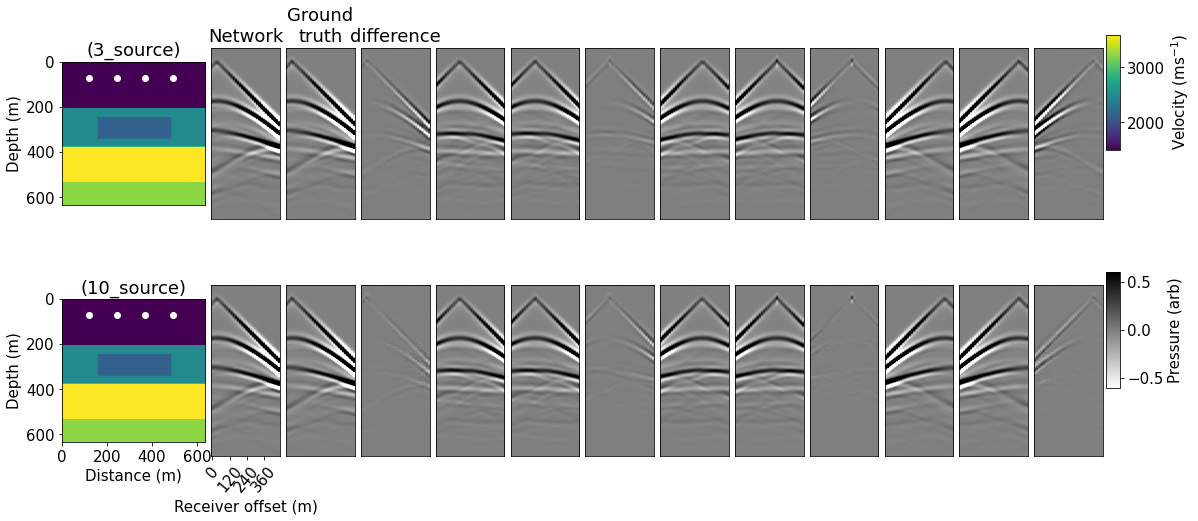

In [60]:
f = plt.figure(figsize=(20,8))

sample_index = 1 
# velocity
plt.subplot2grid((2, 30), (0, 0), colspan=4)
im0 = plt.imshow(inputs_array_3[4*(sample_index-1),0,:,:].T, vmin=CLIM[0], vmax=CLIM[1])
plt.scatter(NX*source_array_3[4*(sample_index-1):4*(sample_index),0,0,0], \
            NX*source_array_3[4*(sample_index-1):4*(sample_index),1,0,0], c="white")
# plt.gca().set_anchor('C')# centre plot
# plt.xticks(np.arange(0,NX,40), (DX*np.arange(0,NX,40)).astype(np.int))
# plt.xlabel("Distance (m)")
plt.xticks([])
plt.yticks(np.arange(0,NZ,40)[::-1], (DZ*np.arange(0,NZ,40)[::-1]).astype(np.int))
plt.xlim(0,NX-1)
plt.ylim(NZ-1,0)
plt.ylabel("Depth (m)")
plt.title("(3_source)")
    
    
for source_i in range(4):

    # gather
    plt.subplot2grid((2, 30), (0, 4+6*source_i), colspan=2)
    im1 = plt.imshow((t_gain*outputs_array_3)[4*(sample_index-1)+source_i,0,:,:].T,
               aspect=0.2, cmap="gray_r", vmin=-VLIM, vmax=VLIM)
#     if source_i==0:
#         plt.xticks(np.arange(0,NREC,8), (DX*DELTARECi*np.arange(0,NREC,8)).astype(np.int))
#         plt.xlabel("Receiver offset (m)")
#         plt.xticks(rotation=50)
#     else: plt.xticks([])
    plt.xticks([])
    plt.yticks([])
    plt.ylim(400,0)
    plt.gca().set_anchor('E')# centre plot
    if source_i==0:
        plt.title("Network")

    # gather
    plt.subplot2grid((2, 30), (0, 4+6*source_i+2), colspan=2)
    plt.imshow((t_gain*labels_array_3)[4*(sample_index-1)+source_i,0,:,:].T,
               aspect=0.2, cmap="gray_r", vmin=-VLIM, vmax=VLIM)
    plt.xticks([])
    plt.yticks([])
    plt.ylim(400,0)
    plt.gca().set_anchor('C')# centre plot
    if source_i==0:
        plt.title("Ground\ntruth")
        
    # difference
    plt.subplot2grid((2, 30), (0, 4+6*source_i+4), colspan=2)
    plt.imshow((t_gain*(labels_array_3-outputs_array_3))[4*(sample_index-1)+source_i,0,:,:].T,
               aspect=0.2, cmap="gray_r", vmin=-VLIM, vmax=VLIM)
    plt.xticks([])
    plt.yticks([])
    plt.ylim(400,0)
    plt.gca().set_anchor('W')# centre plot
    if source_i==0:
        plt.title("difference")

ax = f.add_axes([0.85, 0.68, 0.01, 0.20])
cb = f.colorbar(im0, cax=ax)
cb.ax.set_ylabel('Velocity ($\mathrm{ms}^{-1}$)')

ax = f.add_axes([0.85, 0.267, 0.01, 0.20])
cb = f.colorbar(im1, cax=ax, aspect=0.01)
cb.ax.set_ylabel('Pressure (arb)')

############################################# 10 #####################################
plt.subplot2grid((2, 30), (1, 0), colspan=4)
im0 = plt.imshow(inputs_array_10[4*(sample_index-1),0,:,:].T, vmin=CLIM[0], vmax=CLIM[1])
plt.scatter(NX*source_array_10[4*(sample_index-1):4*(sample_index),0,0,0], \
            NX*source_array_10[4*(sample_index-1):4*(sample_index),1,0,0], c="white")
# plt.gca().set_anchor('C')# centre plot
plt.xticks(np.arange(0,NX,40), (DX*np.arange(0,NX,40)).astype(np.int))
plt.xlabel("Distance (m)")
plt.yticks(np.arange(0,NZ,40)[::-1], (DZ*np.arange(0,NZ,40)[::-1]).astype(np.int))
plt.xlim(0,NX-1)
plt.ylim(NZ-1,0)
plt.ylabel("Depth (m)")
plt.title("(10_source)")
    
    
for source_i in range(4):

    # gather
    plt.subplot2grid((2, 30), (1, 4+6*source_i), colspan=2)
    im1 = plt.imshow((t_gain*outputs_array_10)[4*(sample_index-1)+source_i,0,:,:].T,
               aspect=0.2, cmap="gray_r", vmin=-VLIM, vmax=VLIM)
    if source_i==0:
        plt.xticks(np.arange(0,NREC,8), (DX*DELTARECi*np.arange(0,NREC,8)).astype(np.int))
        plt.xlabel("Receiver offset (m)")
        plt.xticks(rotation=50)
    else: plt.xticks([])
    plt.yticks([])
    plt.ylim(400,0)
    plt.gca().set_anchor('E')# centre plot
#     if source_i==0:
#         plt.title("Network")

    # gather
    plt.subplot2grid((2, 30), (1, 4+6*source_i+2), colspan=2)
    plt.imshow((t_gain*labels_array_10)[4*(sample_index-1)+source_i,0,:,:].T,
               aspect=0.2, cmap="gray_r", vmin=-VLIM, vmax=VLIM)
    plt.xticks([])
    plt.yticks([])
    plt.ylim(400,0)
    plt.gca().set_anchor('C')# centre plot
#     if source_i==0:
#         plt.title("Ground\ntruth")
        
    # difference
    plt.subplot2grid((2, 30), (1, 4+6*source_i+4), colspan=2)
    plt.imshow((t_gain*(labels_array_10-outputs_array_10))[4*(sample_index-1)+source_i,0,:,:].T,
               aspect=0.2, cmap="gray_r", vmin=-VLIM, vmax=VLIM)
    plt.xticks([])
    plt.yticks([])
    plt.ylim(400,0)
    plt.gca().set_anchor('W')# centre plot
#     if source_i==0:
#         plt.title("difference")

figout_dir = './Fig/forward/sources/'
if not os.path.exists(figout_dir):
    os.makedirs(figout_dir)
plt.savefig(figout_dir+'prediction_compasion.png',dpi=300,facecolor='w')#保存图片
plt.show()

# 绘制不同自由度对比图

## 速度模型对比图

In [19]:
path = '../CED_train/'
model, c_dict = load_model("anomalies_freedom4_2000_9sources", rootdir=path+"results/",verbose=False)
# print(c_dict['DATA_PATH'])
# c_dict['DATA_PATH'] = './seismic-simulation-complex-media-master_anomalies/generate_data_Anomalies/data'
# print(c_dict['DATA_PATH'])
rootdir = '../generate_data/data'
anomalies_0 = load_testdataset("anomalies_freedom1_2000_3sources.bin", N_EXAMPLES=6000, c_dict=c_dict, rootdir=rootdir ,verbose=False)
anomalies_1 = load_testdataset("anomalies_freedom2_2000_3sources.bin", N_EXAMPLES=6000, c_dict=c_dict, rootdir=rootdir ,verbose=False)
anomalies_2 = load_testdataset("anomalies_freedom3_2000_3sources.bin", N_EXAMPLES=6000, c_dict=c_dict, rootdir=rootdir ,verbose=False)
anomalies_3 = load_testdataset("anomalies_freedom4_2000_3sources.bin", N_EXAMPLES=6000, c_dict=c_dict, rootdir=rootdir ,verbose=False)
irange = np.arange(0,15,3)#每隔三个提取一个速度模型
anomalies_1.open_file_reader()
samples = [anomalies_1[i] for i in irange]
anomalies_1.close_file_reader()
inputs = [torch.cat([sample["inputs"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["inputs"]))]
labels = [torch.cat([sample["labels"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["labels"]))]
for i in inputs: print(i.shape)
for i in labels: print(i.shape)
# print(inputs)
inputs_array_1 = inputs[0].numpy()
source_array_1 = inputs[1].numpy()
labels_array_1 = labels[0].numpy()
#########################################
irange = np.arange(0,15,3)
anomalies_2.open_file_reader()
samples = [anomalies_2[i] for i in irange]
anomalies_2.close_file_reader()
inputs = [torch.cat([sample["inputs"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["inputs"]))]
labels = [torch.cat([sample["labels"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["labels"]))]
for i in inputs: print(i.shape)
for i in labels: print(i.shape)
# print(inputs)
inputs_array_2 = inputs[0].numpy()
source_array_2 = inputs[1].numpy()
labels_array_2 = labels[0].numpy()
##################################################
irange = np.arange(0,15,3)
anomalies_3.open_file_reader()
samples = [anomalies_3[i] for i in irange]
anomalies_3.close_file_reader()
inputs = [torch.cat([sample["inputs"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["inputs"]))]
labels = [torch.cat([sample["labels"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["labels"]))]
for i in inputs: print(i.shape)
for i in labels: print(i.shape)
# print(inputs)
inputs_array_3 = inputs[0].numpy() 
source_array_3 = inputs[1].numpy()
labels_array_3 = labels[0].numpy()
##################################################



irange = np.arange(0,15,3)#每隔三个提取一个速度模型
anomalies_0.open_file_reader()
samples = [anomalies_0[i] for i in irange]
anomalies_0.close_file_reader()
inputs = [torch.cat([sample["inputs"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["inputs"]))]
labels = [torch.cat([sample["labels"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["labels"]))]
for i in inputs: print(i.shape)
for i in labels: print(i.shape)
# print(inputs)
inputs_array_0 = inputs[0].numpy()
source_array_0 = inputs[1].numpy()
labels_array_0 = labels[0].numpy()
################################################################
inputs_array = np.concatenate((inputs_array_0,inputs_array_1,inputs_array_2,inputs_array_3))#将三种自由度的速度模型拼接起来
labels_array = np.concatenate((labels_array_0,labels_array_1,labels_array_2,labels_array_3))
source_array = np.concatenate((source_array_0,source_array_1,source_array_2,source_array_3))

print(inputs_array.shape)
print(labels_array.shape)
print(source_array.shape)

inputs_array = c_dict["VELOCITY_SIGMA"]*inputs_array + c_dict["VELOCITY_MU"]# 将归一化的数据恢复

Loading model from: ../CED_train/results/models/anomalies_freedom4_2000_9sources/model_00100000.torch
6000 examples
[   0    1    2 ... 5997 5998 5999]
6000 examples
[   0    1    2 ... 5997 5998 5999]
6000 examples
[   0    1    2 ... 5997 5998 5999]
6000 examples
[   0    1    2 ... 5997 5998 5999]
torch.Size([5, 1, 128, 128])
torch.Size([5, 2, 1, 1])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 128, 128])
torch.Size([5, 2, 1, 1])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 128, 128])
torch.Size([5, 2, 1, 1])
torch.Size([5, 1, 32, 512])
torch.Size([5, 1, 128, 128])
torch.Size([5, 2, 1, 1])
torch.Size([5, 1, 32, 512])
(20, 1, 128, 128)
(20, 1, 32, 512)
(20, 2, 1, 1)


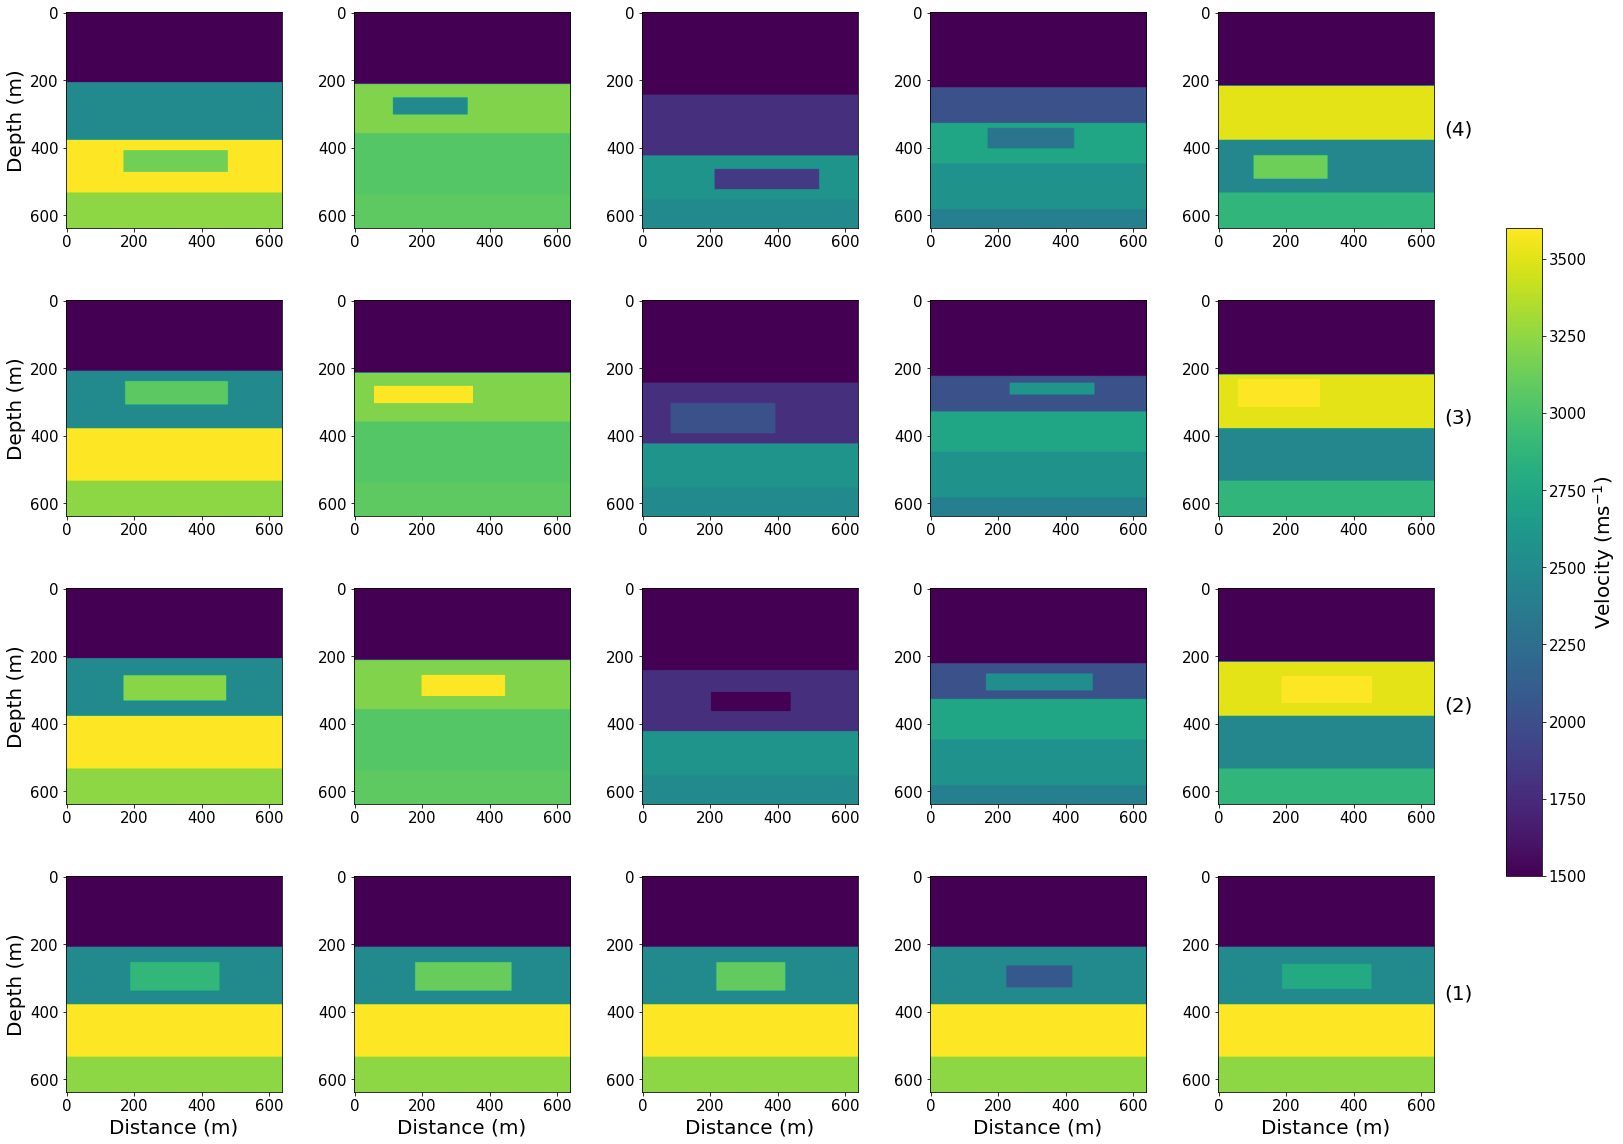

In [20]:
######################## 4自由度
it = iter(modle_freedom) 
%matplotlib inline
f = plt.figure(figsize=(23,17))
for i in range(0,20):
    ax = f.add_axes([(((i%5)*4)+1)/23, (((i//5)*4)+1)/17, 3/23,3/17])
    im0 = plt.imshow(inputs_array[i,0,:,:].T, vmin=CLIM[0], vmax=CLIM[1])
    if i % 5  == 0:
#         plt.yticks(np.arange(0,NZ,40)[::-1], (DZ*np.arange(0,NZ,40)[::-1]).astype(np.int))
        plt.ylabel("Depth (m)",fontsize=20)
    plt.xticks(np.arange(0,NX,40), (DX*np.arange(0,NX,40)).astype(np.int),fontsize=15)
    plt.yticks(np.arange(0,NZ,40)[::-1], (DZ*np.arange(0,NZ,40)[::-1]).astype(np.int),fontsize=15)
    if i <= 4:
        plt.xlabel("Distance (m)",fontsize=20)
    if i==0:
        plt.rcParams['font.size'] = 15 # colorbar字体大小
        ax = f.add_axes([21/23, 4/17, 0.5/23, 9/17])
        cb = f.colorbar(im0, cax=ax)
        cb.ax.set_ylabel('Velocity ($\mathrm{ms}^{-1}$)',fontsize=20)
    if (i+1) % 5 == 0:
        plt.ylabel("(%s)"%(next(it)),fontsize=20,rotation=360,labelpad=25)
        ax.yaxis.set_label_position("right")
#             plt.title("(%s)"%(letters[i]))

figout_dir = './Fig/forward/freedom/'
if not os.path.exists(figout_dir):
    os.makedirs(figout_dir)
plt.savefig(figout_dir+'velocity_comparison.png',dpi=300,facecolor='w')#保存图片
plt.show()

## loss曲线对比图

In [66]:
PATH = ('../CED_train/results/summaries/')
l1loss_test = 'run-.-tag-loss_l1_loss_test.csv'
l1loss_train = 'run-.-tag-loss_l1_loss_train.csv'

modle = ['anomalies_freedom1_2000_3sources/','anomalies_freedom2_2000_3sources/',
        'anomalies_freedom3_2000_3sources/','anomalies_freedom4_2000_3sources/']
x_v = []
x_t = []
y_v = []
y_t = []

for i in range(len(modle)):
    data = pd.read_csv(PATH + modle[i] + l1loss_test)
    x_v.append(data['Step'].tolist())
    y_v.append(data['Value'].tolist())
    data = pd.read_csv(PATH + modle[i] + l1loss_train)
    x_t.append(data['Step'].tolist())
    y_t.append(data['Value'].tolist())
titles = ['(1)','(2)','(3)','(4)']

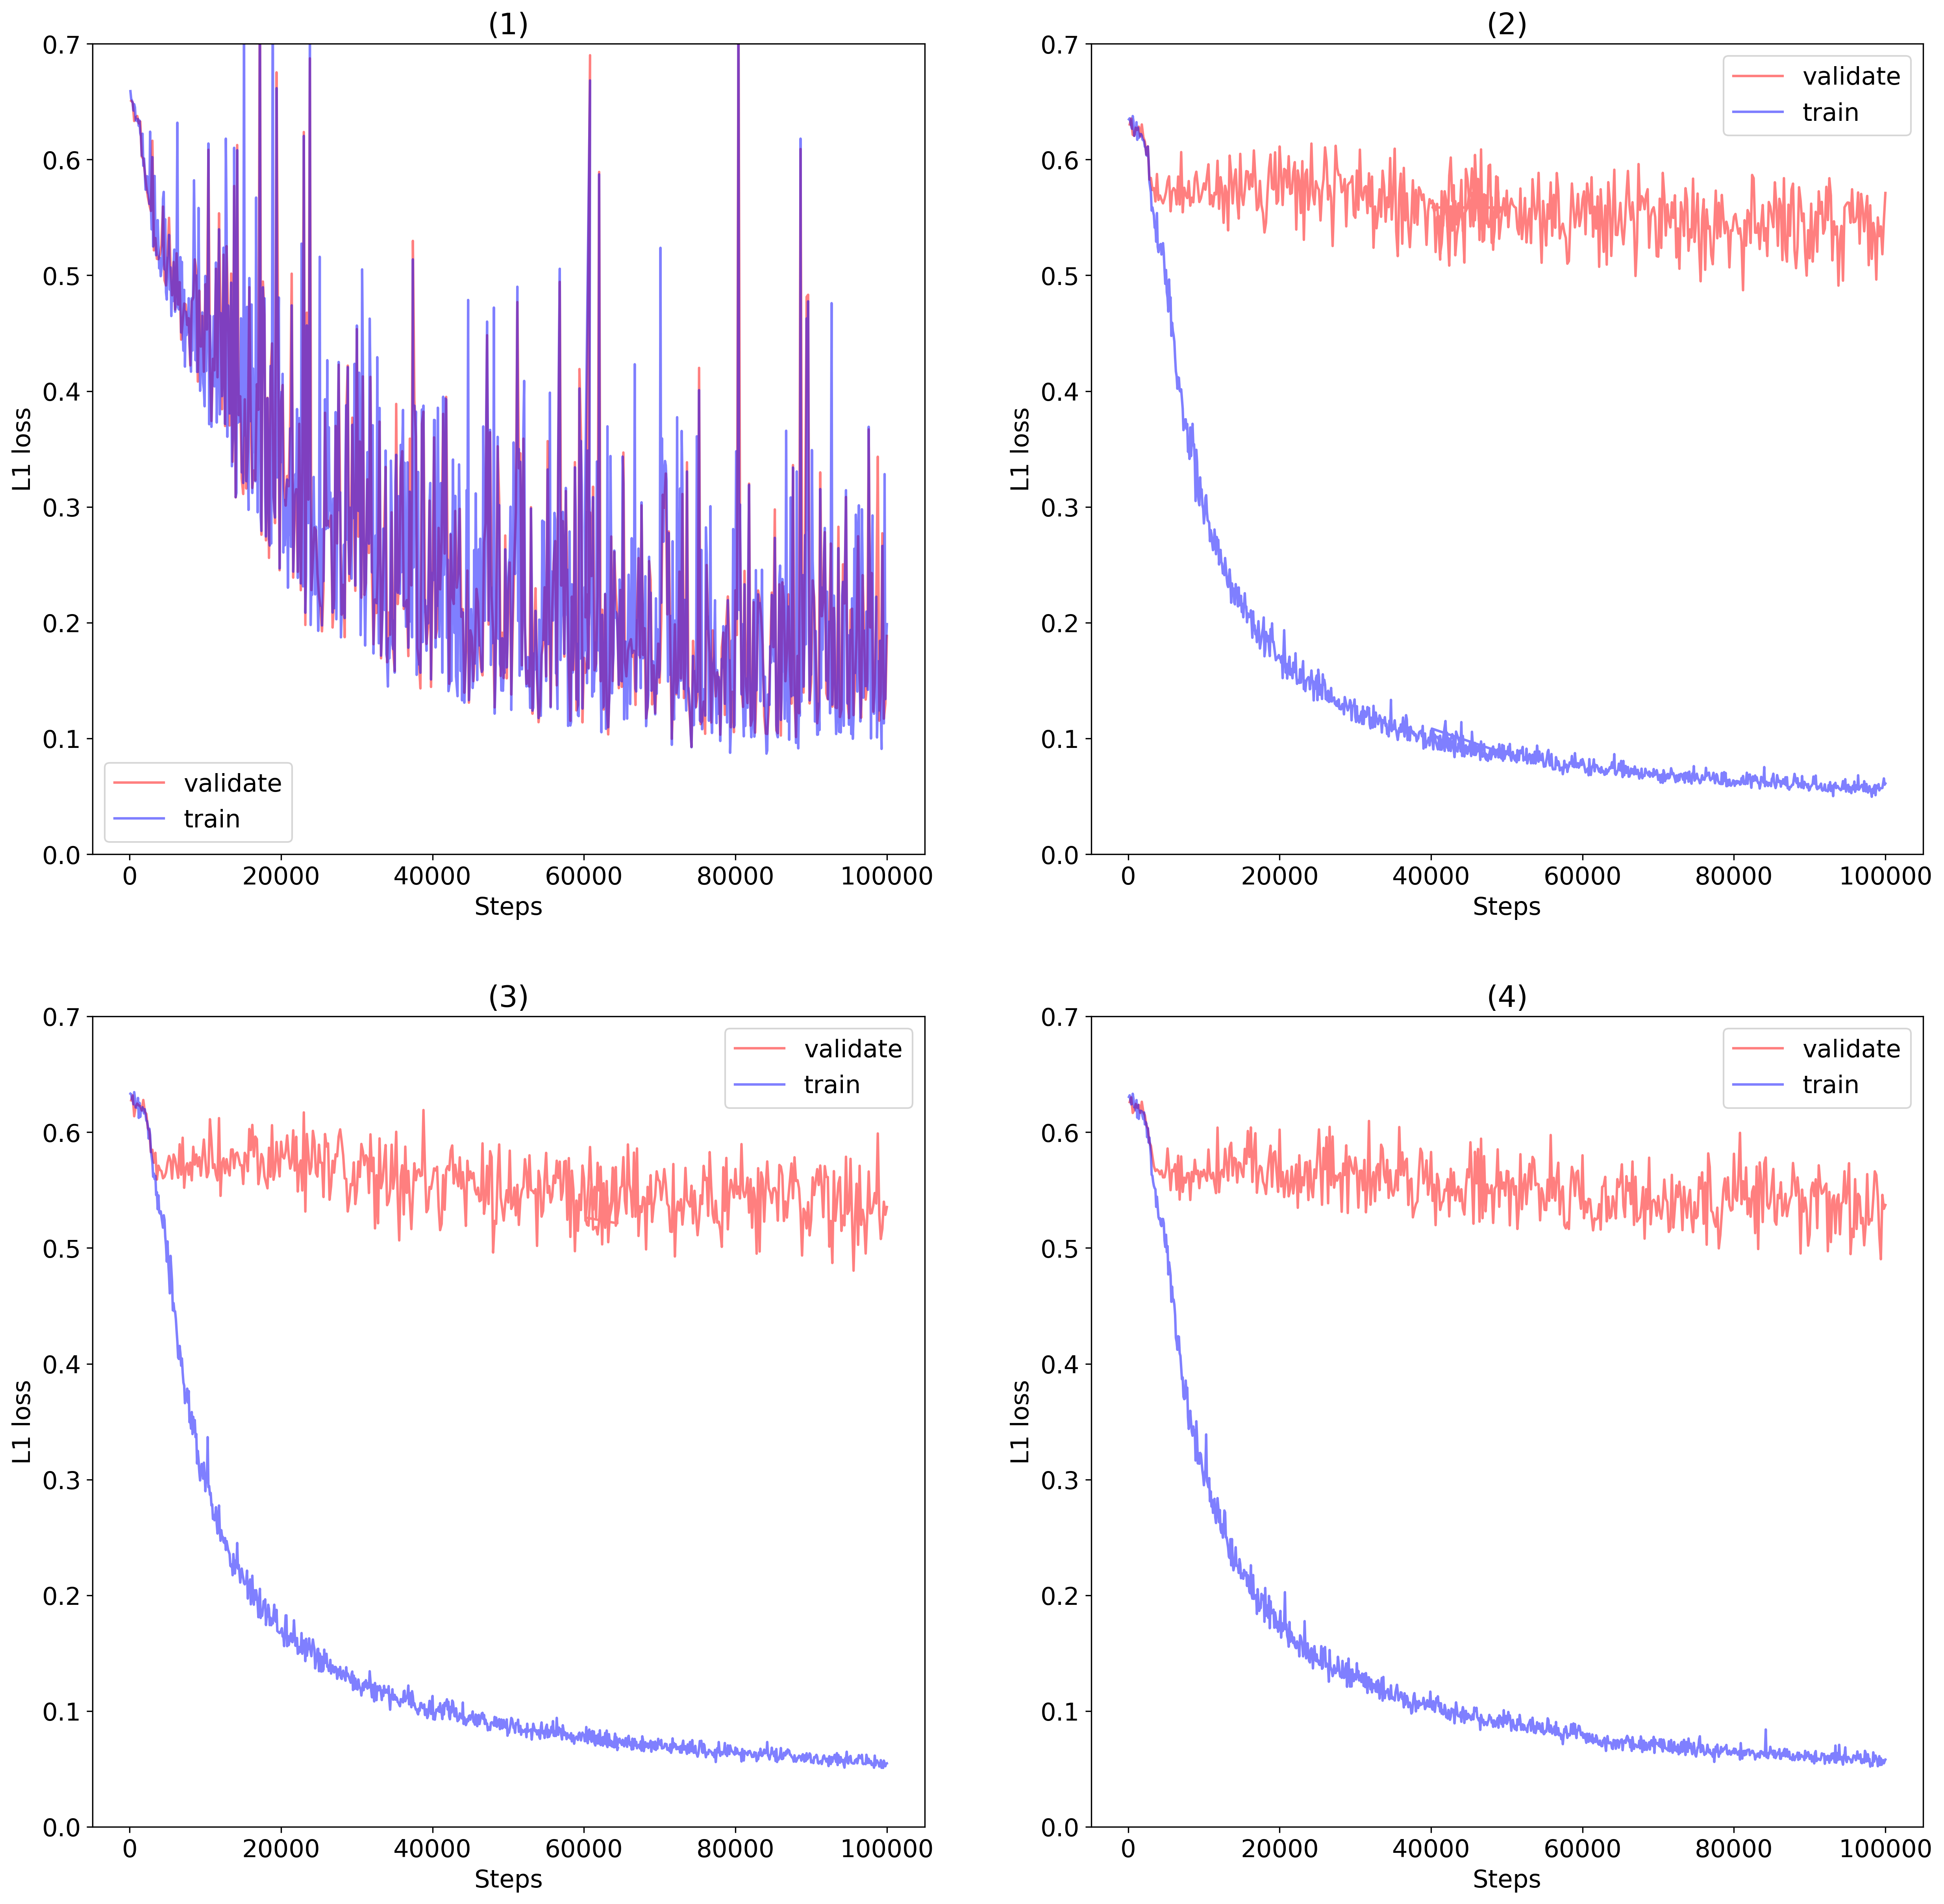

In [74]:
fig = plt.figure(num=1, figsize=(20, 20),dpi=300)     #开启一个窗口，同时设置大小，分辨率
# plt.plot(test_Step,l1loss_test,linestyle='-',alpha=0.5,color='r',label='validate')
# plt.plot(train_Step,l1loss_train,linestyle='-',alpha=0.5,color='b',label='train')
# plt.legend()
# plt.xlabel('Steps')
# plt.ylabel('L1 loss')
# plt.ylim([0,0.8])
# plt.xlim([-5000,105000])
# plt.title('')
# plt.savefig('./Fig/forward/samples/freedom4_2000_9sources_loss.png',dpi=300,facecolor='w')#保存图片
for i in range(len(modle)):
    plt.subplot(2,2,i+1)
    plt.plot(x_v[i],y_v[i],linestyle='-',alpha=0.5,color='r',label='validate')
    plt.plot(x_t[i],y_t[i],linestyle='-',alpha=0.5,color='b',label='train')
    plt.legend()
    plt.xlabel('Steps')
    plt.ylabel('L1 loss')
    plt.ylim([0,0.7])
    plt.title('%s'%titles[i])
    
figout_dir = './Fig/forward/freedom/'
if not os.path.exists(figout_dir):
    os.makedirs(figout_dir)   
plt.savefig(figout_dir+'loss_comparison.png',dpi=300,facecolor='w')#保存图片

# 不同样本容量对比图

## loss曲线对比图

In [77]:
PATH = ('../CED_train/results/summaries/')
l1loss_test = 'run-.-tag-loss_l1_loss_test.csv'
l1loss_train = 'run-.-tag-loss_l1_loss_train.csv'

modle = ['anomalies_freedom4_2000_3sources/','anomalies_freedom4_2000_6sources/','anomalies_freedom4_2000_9sources/']
x_v = []
x_t = []
y_v = []
y_t = []

for i in range(len(modle)):
    data = pd.read_csv(PATH + modle[i] + l1loss_test)
    x_v.append(data['Step'].tolist())
    y_v.append(data['Value'].tolist())
    data = pd.read_csv(PATH + modle[i] + l1loss_train)
    x_t.append(data['Step'].tolist())
    y_t.append(data['Value'].tolist())
titles = ['6000 examples','12000 examples','18000 examples']

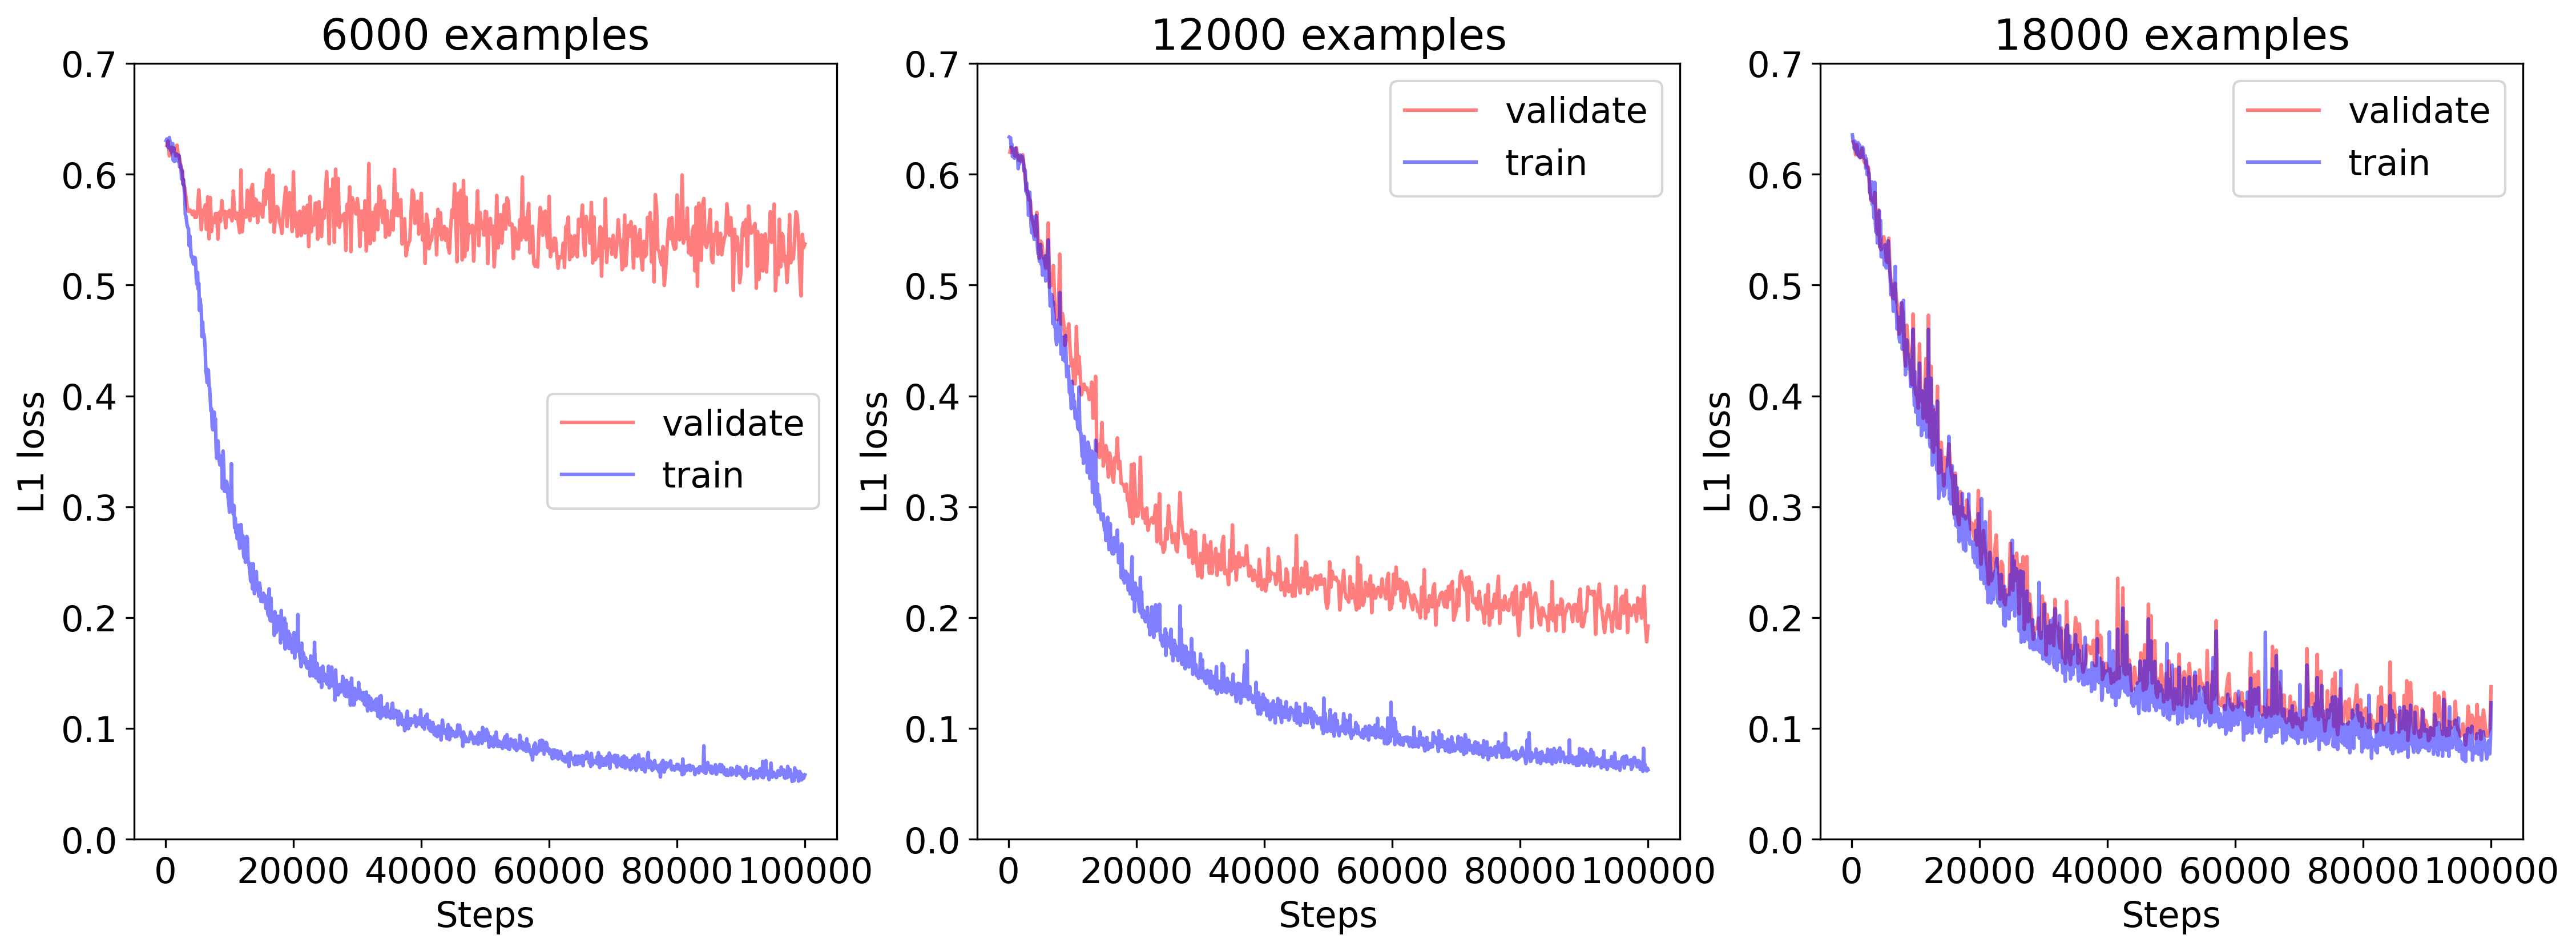

In [80]:
fig = plt.figure(num=1, figsize=(18, 6),dpi=300)     #开启一个窗口，同时设置大小，分辨率
# plt.plot(test_Step,l1loss_test,linestyle='-',alpha=0.5,color='r',label='validate')
# plt.plot(train_Step,l1loss_train,linestyle='-',alpha=0.5,color='b',label='train')
# plt.legend()
# plt.xlabel('Steps')
# plt.ylabel('L1 loss')
# plt.ylim([0,0.8])
# plt.xlim([-5000,105000])
# plt.title('')
# plt.savefig('./Fig/forward/samples/freedom4_2000_9sources_loss.png',dpi=300,facecolor='w')#保存图片
for i in range(len(modle)):
    plt.subplot(1,3,i+1)
    plt.plot(x_v[i],y_v[i],linestyle='-',alpha=0.5,color='r',label='validate')
    plt.plot(x_t[i],y_t[i],linestyle='-',alpha=0.5,color='b',label='train')
    plt.legend()
    plt.xlabel('Steps')
    plt.ylabel('L1 loss')
    plt.ylim([0,0.7])
    plt.title('%s'%titles[i])
    
figout_dir = './Fig/forward/samples/'
if not os.path.exists(figout_dir):
    os.makedirs(figout_dir)
    
plt.savefig(figout_dir+'loss_comparison.png',dpi=300,facecolor='w')#保存图片

## 绘制网络正演预测结果图

In [21]:
path = '../CED_train/'
model, c_dict = load_model("anomalies_freedom4_2000_9sources/model_00100000.torch", rootdir=path+"results/",verbose=False)
# print(c_dict['DATA_PATH'])
# c_dict['DATA_PATH'] = './seismic-simulation-complex-media-master_anomalies/generate_data_Anomalies/data'
# print(c_dict['DATA_PATH'])
rootdir = '../generate_data/data'
d = load_testdataset("anomalies_freedom4_100_3sources_validate.bin", N_EXAMPLES=300, c_dict=c_dict, rootdir=rootdir,verbose=False)

# Get batches of test data
irange = np.arange(300)

d.open_file_reader()
samples = [d[i] for i in irange]
d.close_file_reader()
inputs = [torch.cat([sample["inputs"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["inputs"]))]
labels = [torch.cat([sample["labels"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["labels"]))]
for i in inputs: print(i.shape)
for i in labels: print(i.shape)

# Inference
with torch.no_grad():# faster inference without tracking
    model.eval()
    outputs = model(*inputs)

    inputs_array = inputs[0].detach().cpu().numpy().copy()# detach returns a new tensor, detached from the current graph
    source_array = inputs[1].detach().cpu().numpy().copy()
    outputs_array = outputs[0].detach().cpu().numpy().copy()
    labels_array = labels[0].detach().cpu().numpy().copy()
    print(outputs_array.shape)

# un-normalise velocity
#由于在生成数据时使用了对数正态分布
#而在 autoencoder 的dataset.py对数据进行了归一化处理（preprosess）
#所以在正式画图时，需要对数据复原
inputs_array = c_dict["VELOCITY_SIGMA"]*inputs_array + c_dict["VELOCITY_MU"]

Loading model from: ../CED_train/results/models/anomalies_freedom4_2000_9sources/model_00100000.torch
300 examples
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 

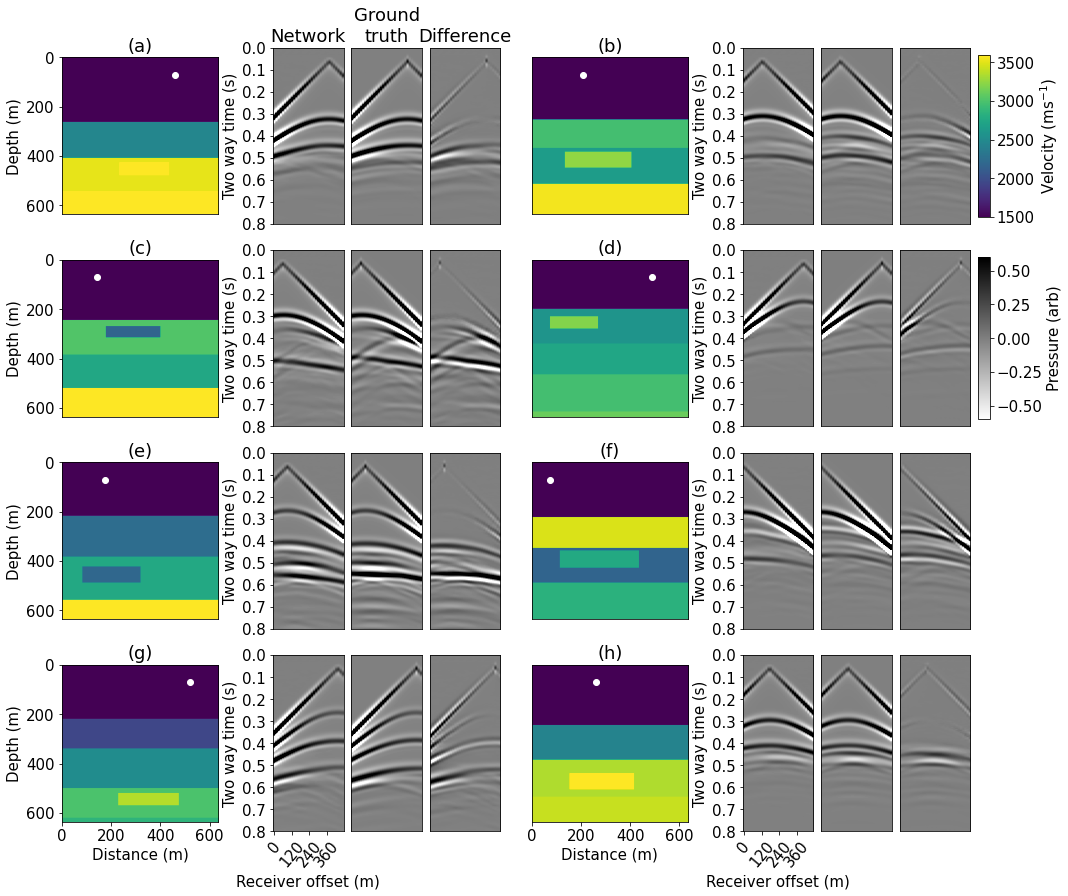

In [25]:
index = 0
ibs = np.arange((index-1)*24,(index)*24,3)+0# as velocity model goes in threes
f = plt.figure(figsize=0.9*np.array([14.5,12.5]))
for i in range(0,8):
    ib = ibs[i]
    
    # velocity
    ncol=12
    nrow=4
    ax = f.add_axes([(6*(i%2)+0)/ncol, (nrow-1-i//2)/nrow, 2/ncol, 1/nrow])# xmin, ymin, dx, and dy
    
    im0 = plt.imshow(inputs_array[ib,0,:,:].T, vmin=CLIM[0], vmax=CLIM[1])
    plt.scatter(NX*source_array[ib,0,:,:], NX*source_array[ib,1,:,:], c="white")
    if i//2 == 3:
        plt.xticks(np.arange(0,NX,40), (DX*np.arange(0,NX,40)).astype(np.int))
        plt.xlabel("Distance (m)")
    else: plt.xticks([])
    if i%2==0:
        plt.yticks(np.arange(0,NZ,40)[::-1], (DZ*np.arange(0,NZ,40)[::-1]).astype(np.int))
        plt.ylabel("Depth (m)")
    else: plt.yticks([])
    plt.xlim(0,NX-1)
    plt.ylim(NZ-1,0)
    plt.title("(%s)"%(letters[i]))
    
    # gather (NN)
    ax = f.add_axes([(6*(i%2)+2.7)/ncol, (nrow-1-i//2)/nrow, 0.9/ncol, 1/nrow])# xmin, ymin, dx, and dy
    
    im1 = plt.imshow((t_gain*outputs_array)[ib,0,:,:].T,
               aspect=0.2, cmap="gray_r", vmin=-VLIM, vmax=VLIM)
    if i//2 == 3:
        plt.xticks(np.arange(0,NREC,8), (DX*DELTARECi*np.arange(0,NREC,8)).astype(np.int))
        plt.xlabel("Receiver offset (m)")
        plt.xticks(rotation=50)
    else: plt.xticks([])
    plt.yticks(np.arange(0,NSTEPS,50)[::-1], (["%.1f"%(val) for val in DT*np.arange(0,NSTEPS,50)[::-1]]))
    plt.ylabel("Two way time (s)")
    plt.ylim(400,0)
    if i==0:
        plt.title("Network")
    
    # gather (Ground truth)
    ax = f.add_axes([(6*(i%2)+3.7)/ncol, (nrow-1-i//2)/nrow, 0.9/ncol, 1/nrow])# xmin, ymin, dx, and dy
    
    plt.imshow((t_gain*labels_array)[ib,0,:,:].T,
               aspect=0.2, cmap="gray_r", vmin=-VLIM, vmax=VLIM)
    plt.xticks([])
    plt.yticks([])
    plt.ylim(400,0)
    if i==0:
        plt.title("Ground\ntruth")
        
    # gather (diff)
    ax = f.add_axes([(6*(i%2)+4.7)/ncol, (nrow-1-i//2)/nrow, 0.9/ncol, 1/nrow])# xmin, ymin, dx, and dy
    
    plt.imshow((t_gain*(labels_array-outputs_array))[ib,0,:,:].T,
               aspect=0.2, cmap="gray_r", vmin=-VLIM, vmax=VLIM)
    plt.xticks([])
    plt.yticks([])
    plt.ylim(400,0)
    if i==0:
        plt.title("Difference")

    if i==0:
        ax = f.add_axes([11.7/ncol, 3.1/nrow, 0.15/ncol, 0.8/nrow])
        cb = f.colorbar(im0, cax=ax)
        cb.ax.set_ylabel('Velocity ($\mathrm{ms}^{-1}$)')
        
        ax = f.add_axes([11.7/ncol, 2.1/nrow, 0.15/ncol, 0.8/nrow])
        cb = f.colorbar(im1, cax=ax, aspect=0.01)
        cb.ax.set_ylabel('Pressure (arb)')
        
figout_dir = './Fig/forward/samples/'
if not os.path.exists(figout_dir):
    os.makedirs(figout_dir)
plt.savefig(figout_dir+"freedom4_2000_9sources_prediction.png", bbox_inches='tight', pad_inches=0.01, dpi=300,facecolor='w')
plt.show()

# 地震反演

## 反演loss曲线对比图

## 绘制网络反演结果预测图

In [6]:
path = '../CED_train/'
model, c_dict = load_model("anomalies_freedom4_2000_9sources_inverse/model_00100000.torch", rootdir=path+"results/",verbose=False)
rootdir = '../generate_data/data'
d = load_testdataset("anomalies_freedom4_100_3sources_validate.bin", N_EXAMPLES=300, c_dict=c_dict, rootdir=rootdir,verbose=False)


# Get batches of test data
irange = np.arange(300)

d.open_file_reader()
samples = [d[i] for i in irange]
d.close_file_reader()
labels= [torch.cat([sample["inputs"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["inputs"]))]
inputs = [torch.cat([sample["labels"][i].unsqueeze(0) for sample in samples]) for i in range(len(samples[0]["labels"]))]
for i in inputs: print(i.shape)
for i in labels: print(i.shape)
inputs.extend(labels[1:2])
del labels[1]
for i in inputs: print(i.shape)
for i in labels: print(i.shape)
# Inference
with torch.no_grad():# faster inference without tracking
    model.eval()
    outputs = model(*inputs)

    inputs_array = inputs[0].detach().cpu().numpy().copy()# detach returns a new tensor, detached from the current graph
    source_array = inputs[1].detach().cpu().numpy().copy()
    outputs_array = outputs[0].detach().cpu().numpy().copy()
    labels_array = labels[0].detach().cpu().numpy().copy()
    print(outputs_array.shape)

# # un-normalise velocity
# #由于在生成数据时使用了对数正态分布
# #而在 autoencoder 的dataset.py对数据进行了归一化处理（preprosess）
# #所以在正式画图时，需要对数据复原
labels_array = c_dict["VELOCITY_SIGMA"]*labels_array + c_dict["VELOCITY_MU"]
outputs_array = c_dict["VELOCITY_SIGMA"]*outputs_array + c_dict["VELOCITY_MU"]

Loading model from: ../CED_train/results/models/anomalies_freedom4_2000_9sources_inverse/model_00100000.torch
300 examples
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 

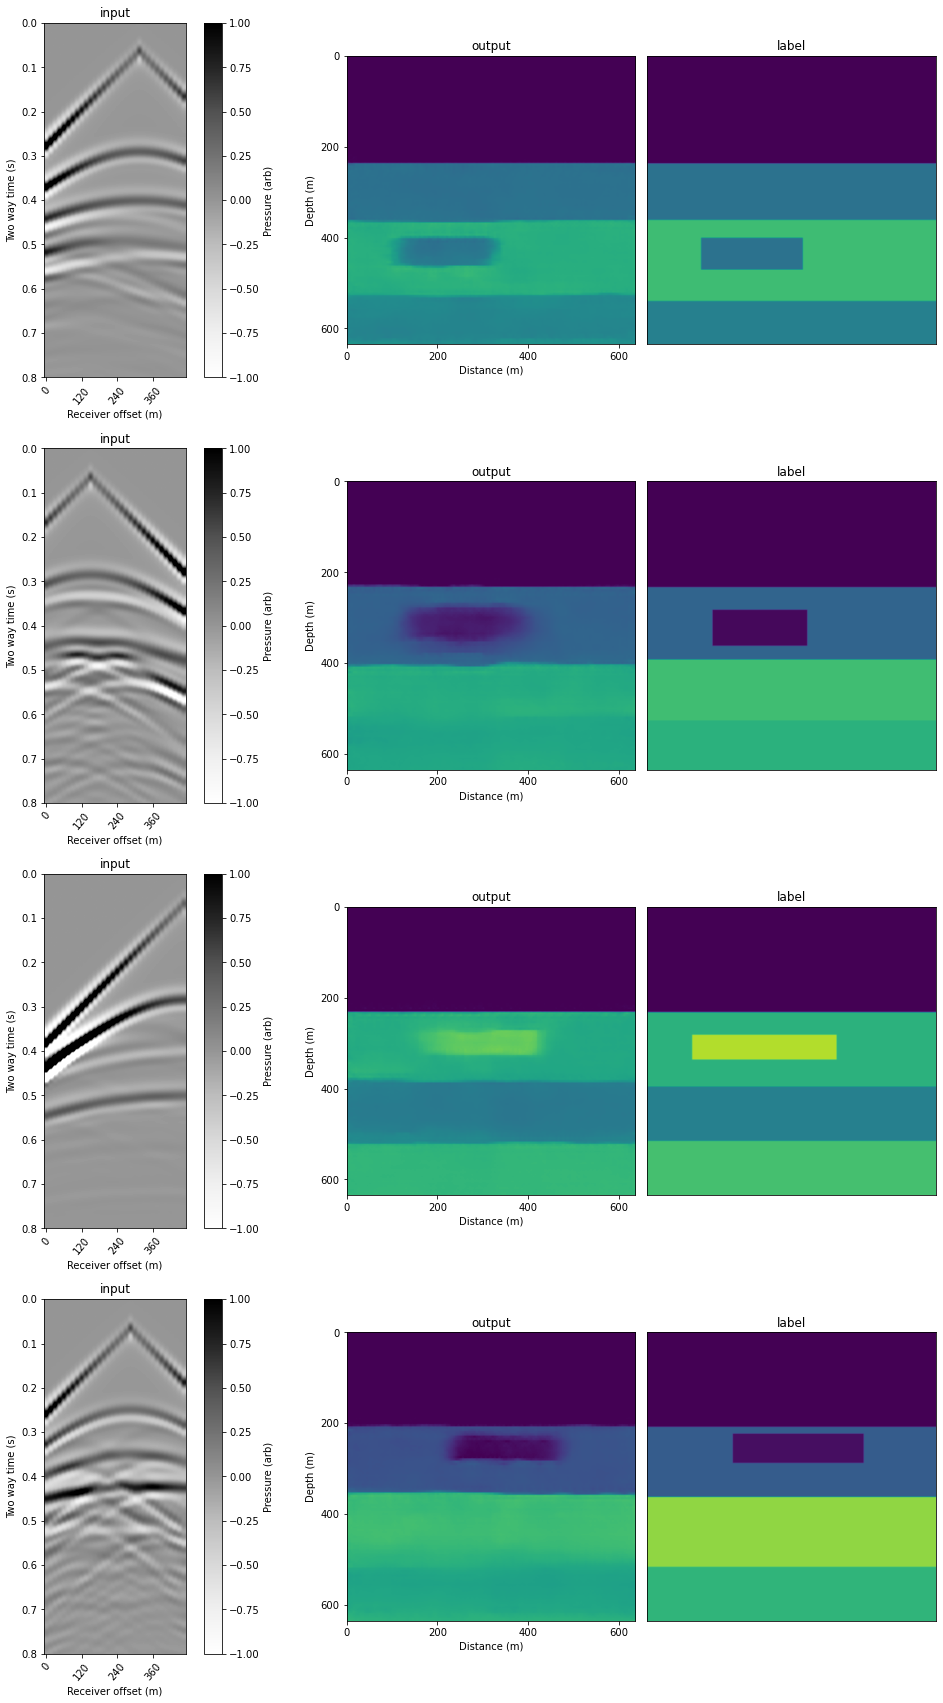

In [10]:
%matplotlib inline
ib = 28
f = plt.figure(figsize=(20,30))
index = [0,222,178,132]
for i in range(4):
    plt.subplot2grid((4, 15), (i, 0), colspan=5)
    plt.imshow((t_gain*inputs_array)[index[i],0,:,:].T,
                   aspect=0.2, cmap="Greys", vmin=-1, vmax=1)
    plt.title('input')
    plt.yticks(np.arange(0,NSTEPS,50)[::-1], (["%.1f"%(val) for val in DT*np.arange(0,NSTEPS,50)[::-1]]))
    plt.ylabel("Two way time (s)")
    plt.ylim(400,0)
    plt.xticks(np.arange(0,NREC,8), (DX*DELTARECi*np.arange(0,NREC,8)).astype(np.int))
    plt.xlabel("Receiver offset (m)")
    plt.xticks(rotation=50)
    # ax = f.add_axes([0.99, 0.8, 0.01, 0.20])
    xx=plt.colorbar()
    xx.ax.set_ylabel('Pressure (arb)')
    # cb.ax.set_ylabel('Velocity ($\mathrm{ms}^{-1}$)')
    plt.subplot2grid((4, 15), (i, 6), colspan=4)
    im0=plt.imshow(outputs_array[index[i],0,:,:].T,vmin=CLIM[0], vmax=CLIM[1])
    plt.title('output')
    plt.xticks(np.arange(0,NX,40), (DX*np.arange(0,NX,40)).astype(np.int))
    plt.xlabel("Distance (m)")
    plt.yticks(np.arange(0,NZ,40)[::-1], (DZ*np.arange(0,NZ,40)[::-1]).astype(np.int))
    plt.xlim(0,NX-1)
    plt.ylim(NZ-1,0)
    plt.ylabel("Depth (m)")

    plt.subplot2grid((4, 15), (i, 10), colspan=4)
    plt.imshow(labels_array[index[i],0,:,:].T, vmin=CLIM[0], vmax=CLIM[1])
    plt.title('label')
    plt.xticks([])
    # plt.xlabel("Distance (m)")
    plt.yticks([])
    # plt.xlim(0,NX-1)
    # plt.ylim(NZ-1,0)
    # plt.ylabel("Depth (m)")
# ax = f.add_axes([13/15, 0.2, 0.2/15, 0.6])
# cb = f.colorbar(im0, cax=ax)
# cb.ax.set_ylabel('Velocity ($\mathrm{ms}^{-1}$)')
figout_dir = './Fig/inverse/'
if not os.path.exists(figout_dir):
    os.makedirs(figout_dir)
plt.savefig(figout_dir+"freedom4_2000_9sources_inverse_prediction.png", bbox_inches='tight', pad_inches=0.01, dpi=300,facecolor='w')